### Бабушкина Татьяна

### Визуализация (создание анимации) градиентного спуска

In [12]:
import numpy as np
import gzip
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import expit
import celluloid
from celluloid import Camera
from matplotlib import animation 

In [13]:
# Открываем файлы MNIST: 
def open_images(filename):
    with gzip.open(filename, "rb") as file:     
        data=file.read()
        return np.frombuffer(data,dtype=np.uint8, offset=16).reshape(-1,28,28).astype(np.float32) 

def open_labels(filename):
    with gzip.open(filename,"rb") as file:
        data = file.read()
        return np.frombuffer(data,dtype=np.uint8, offset=8).astype(np.float32) 
    
X_train=open_images("train-images-idx3-ubyte.gz").reshape(-1,784).astype(np.float32) 
X_train=X_train/255 # rescale pixel values to 0-1

y_train=open_labels("train-labels-idx1-ubyte.gz")
oh=OneHotEncoder(categories='auto') 
y_train_oh=oh.fit_transform(y_train.reshape(-1,1)).toarray() # one-hot-encoding of y-values

In [14]:
hidden_0=50 # количество узлов первого скрытого слоя 
hidden_1=500 # количество узлов второго скрытого слоя 

# Зададим функцию потерь:
def costs(x,y,w_a,w_b,seed_):  
        np.random.seed(seed_) # задаем инициализатор генератора случайных чисел 
        w0=np.random.randn(hidden_0,784)  # матрица весов 1-го скрытого слоя
        w1=np.random.randn(hidden_1,hidden_0) # матрица весов 2-го скрытого слоя
        w2=np.random.randn(10,hidden_1) # матрица весов выходного слоя
        w2[5][250] = w_a # задаем значение веса w_250,5(2)
        w2[5][251] = w_b # задаем значение веса w_251,5(2)
        a0 = expit(w0 @ x.T)  # выход 1-го скрытого слоя 
        a1=expit(w1 @ a0)  # выход 2-го скрытого слоя 
        pred= expit(w2 @ a1) # выход последнего слоя 
        return np.mean(np.sum((y-pred)**2,axis=0)) # потери w.r.t. w_a и w_b

In [15]:
# Зададим набор значений для ячеистой сети: 
m1s = np.linspace(-15, 17, 40)   
m2s = np.linspace(-15, 18, 40)  
M1, M2 = np.meshgrid(m1s, m2s) # создаем ячеистую сеть  

# Определим потери для каждой координаты ячеистой сети: 
zs_100 = np.array([costs(X_train[0:100],y_train_oh[0:100].T  
                               ,np.array([[mp1]]), np.array([[mp2]]),135)  
                        for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_100 = zs_100.reshape(M1.shape) # Значения z для N=100

zs_10000 = np.array([costs(X_train[0:10000],y_train_oh[0:10000].T  
                               ,np.array([[mp1]]), np.array([[mp2]]),135)  
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_10000 = zs_10000.reshape(M1.shape) # Значения z для N=10,000

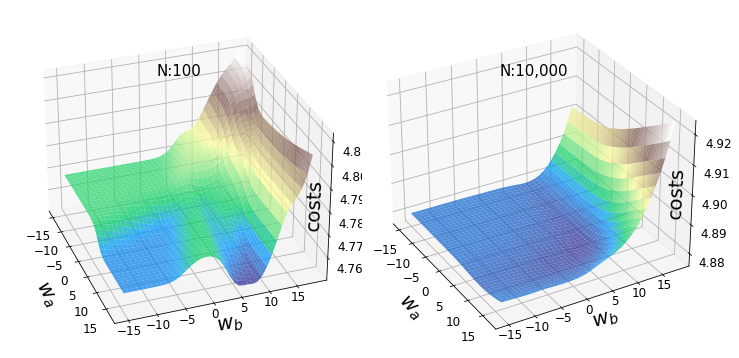

In [16]:
# Рисуем ландшафты функции потерь: 
fig = plt.figure(figsize=(10,7.5)) # создаем фигуру
ax0 = fig.add_subplot(121, projection='3d' )
ax1 = fig.add_subplot(122, projection='3d' )

fontsize_=20 # задаем размер шрифта для меток осей 
labelsize_=12 # задаем размер меток делений 

# Настраиваем дочерние рисунки (subplots): 
ax0.view_init(elev=30, azim=-20)
ax0.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax0.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax0.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax0.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax0.set_title('N:100',y=0.85,fontsize=15) # задаем заголовок дочернего рисунка

ax1.view_init(elev=30, azim=-30)
ax1.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax1.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax1.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax1.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax1.set_title('N:10,000',y=0.85,fontsize=15)

# Поверхностные графики потерь (= ландшафты функции потерь):  
ax0.plot_surface(M1, M2, Z_100, cmap='terrain', #поверхностный график
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
ax1.plot_surface(M1, M2, Z_10000, cmap='terrain', #поверхностный график
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
plt.tight_layout()
plt.show()

In [17]:
# Сохраняем значения потерь и весов в списках: 
weights_2_5_250=[] 
weights_2_5_251=[] 
costs=[] 

seed_= 135 # для инициализации генератора случайных чисел
N=100 # размер выборки 

# Задаем нейронную сеть: 
class NeuralNetwork(object):
    def __init__(self, lr=0.01):
        self.lr=lr
        np.random.seed(seed_) # Инициализируем генератор случайных чисел
        # Инициализируем матрицы весов: 
        self.w0=np.random.randn(hidden_0,784)  
        self.w1=np.random.randn(hidden_1,hidden_0)
        self.w2=np.random.randn(10,hidden_1)
        self.w2[5][250] = start_a # задать стартовое значение для w_a
        self.w2[5][251] = start_b # задать стартовое значение для w_b
    
    def train(self, X,y):
        a0 = expit(self.w0 @ X.T)  
        a1=expit(self.w1 @ a0)  
        pred= expit(self.w2 @ a1)
        # Частные производные функции потерь w.r.t. весов выходного слоя: 
        dw2= (pred - y.T)*pred*(1-pred)  @ a1.T / len(X)   # ... среднее по выборке
        # Обновляем веса: 
        self.w2[5][250]=self.w2[5][250] - self.lr * dw2[5][250] 
        self.w2[5][251]=self.w2[5][251] - self.lr * dw2[5][251] 
        costs.append(self.cost(pred,y)) # дописываем значения потерь в список
    
    def cost(self, pred, y):
        return np.mean(np.sum((y.T-pred)**2,axis=0))

In [18]:
# Начальные значения w_a/w_b: 
starting_points = [  (-9,15),(-10.1,15),(-11,15)] 

for j in starting_points:
    start_a,start_b=j
    model=NeuralNetwork(10) # установить скорость обучения в 10
    for i in range(10000):  # 10,000 эпох           
        model.train(X_train[0:N], y_train_oh[0:N]) 
        weights_2_5_250.append(model.w2[5][250]) # дописываем значения весов в список
        weights_2_5_251.append(model.w2[5][251]) # дописываем значения весов в список

# Create sublists of costs and weight values for each starting point: 
costs = np.split(np.array(costs),3) 
weights_2_5_250 = np.split(np.array(weights_2_5_250),3)
weights_2_5_251 = np.split(np.array(weights_2_5_251),3)

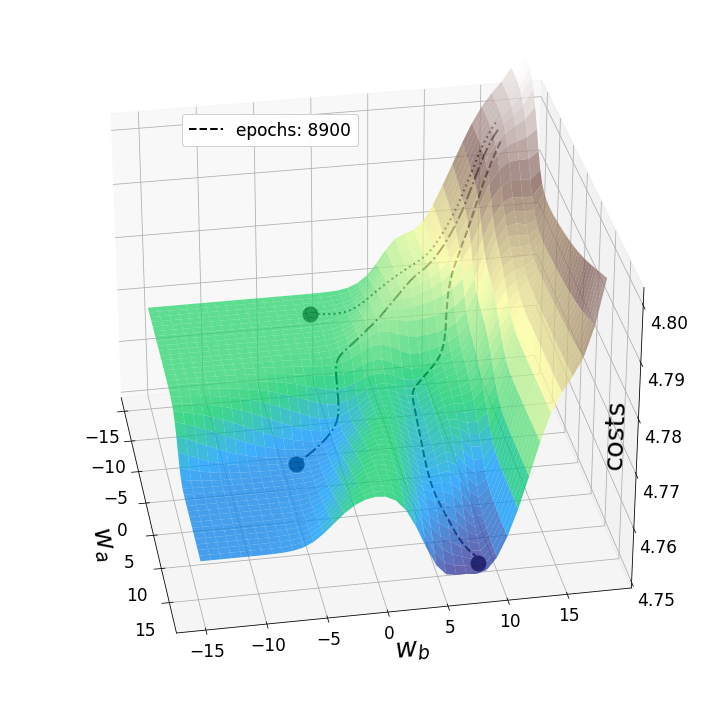

In [19]:
fig = plt.figure(figsize=(10,10)) # создаем фигуру
ax = fig.add_subplot(111,projection='3d' ) 
line_style=["dashed", "dashdot", "dotted"] # стили линий
fontsize_=27 # задаем размер шрифта для меток осей 
labelsize_=17 # задаем размер шрифта для меток делений
ax.view_init(elev=30, azim=-10)
ax.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=17)
ax.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=5)
ax.set_zlabel("costs", fontsize=fontsize_, labelpad=-35)
ax.tick_params(axis='x', pad=12, which='major', labelsize=labelsize_)
ax.tick_params(axis='y', pad=0, which='major', labelsize=labelsize_)
ax.tick_params(axis='z', pad=8, which='major', labelsize=labelsize_)
ax.set_zlim(4.75,4.802) # задаем диапазон значений по z в графике

# Определяем, график каких эпох рисовать:
p1=list(np.arange(0,200,20))
p2=list(np.arange(200,9000,100))
points_=p1+p2

camera=Camera(fig) # создаем объект Camera
for i in points_:
    # Рисуем три траектории градиентного спуска...
    #... каждая начинается из своей начальной точки
    #... и имеет собственный уникальный стиль линии:
    for j in range(3): 
        ax.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],costs[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))
        ax.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],costs[j][i],
                   marker='o', s=15**2,
               color="black", alpha=1.0)
    # Surface plot (= loss landscape):
    ax.plot_surface(M1, M2, Z_100, cmap='terrain', 
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
    ax.legend([f'epochs: {i}'], loc=(0.25, 0.8),fontsize=17) # позиция надписи
    plt.tight_layout() 
    camera.snap() # сделать снимок после каждой итерации
    
animation = camera.animate(interval = 5, # интервал между фреймами в миллисекундах
                          repeat = False,
                          repeat_delay = 0)
animation.save('gd_1.gif', writer = 'imagemagick', dpi=100)  # сохраним анимацию  

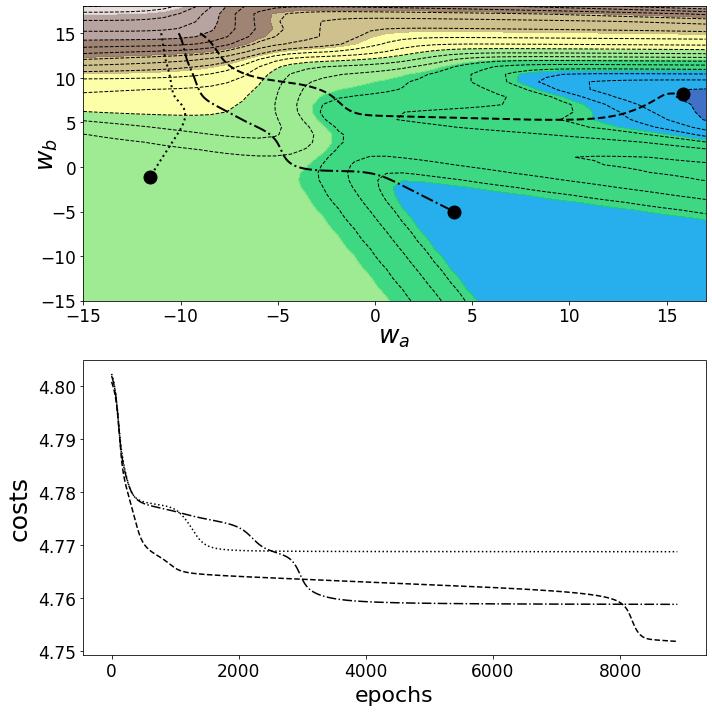

In [20]:
fig = plt.figure(figsize=(10,10)) # создаем фигуру
ax0=fig.add_subplot(2, 1, 1) 
ax1=fig.add_subplot(2, 1, 2) 

# Задаем параметры дочерних рисунков (subplots): 
ax0.set_xlabel(r'$w_a$', fontsize=25, labelpad=0)
ax0.set_ylabel(r'$w_b$', fontsize=25, labelpad=-20)
ax0.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlabel("epochs", fontsize=22, labelpad=5)
ax1.set_ylabel("costs", fontsize=25, labelpad=7)
ax1.tick_params(axis='both', which='major', labelsize=17)

contours_=21 # задаем количество контурных линий
points_=np.arange(0,9000,100) # определяем, какие эпохи рисовать

camera = Camera(fig) # создаем объект Camera
for i in points_:
    cf=ax0.contour(M1, M2, Z_100,contours_, colors='black', # контурный график
                     linestyles='dashed', linewidths=1)
    ax0.contourf(M1, M2, Z_100, alpha=0.85,cmap='terrain') # контурные графики с заливкой 
    
    for j in range(3):
        ax0.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],marker='o', s=13**2,
               color="black", alpha=1.0)
        ax0.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))
        
        ax1.plot(costs[j][0:i], color="black", linestyle=line_style[j])
    plt.tight_layout()
    camera.snap()
    
animation = camera.animate(interval = 5,
                          repeat = True, repeat_delay = 0)  # создаем анимацию 
animation.save('gd_2.gif', writer = 'imagemagick')  # сохраняем анимацию в gif